# Surprise Housing- Adavnce Regression

### Steps involving in prediction of SalePrice
- Data Understanding.
- Data Exploration and Preproccessing
- Feature Engineering and Scalling
- Residual Analysis
- Model Building & Evaluation


In [263]:
# importing libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.metrics import r2_score
import datetime

In [264]:
housing = pd.read_csv("train.csv")

## Data Understanding

In [265]:
# shape of the dataset
housing.shape

(1460, 81)

In [266]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [267]:
# We need to drop Id Column as it does not make sence for further analysis
housing = housing.drop('Id', axis=1)

In [268]:
# check the categorical, numerical and orinal features in dataset.
cat_count = housing.select_dtypes(include=['object']).shape[1]
num_count = housing.select_dtypes(include=['int64','float64']).shape[1]

print(f"Categorical Features: {cat_count}, and Numerical Features: {num_count}")

Categorical Features: 43, and Numerical Features: 37


In [269]:
ordinal_ = ['MSSubClass','OverallQual','OverallCond','ExterQual', 'ExterCond', 'HeatingQC','BsmtQual', 'BsmtCond', 'FireplaceQu','GarageQual','GarageCond','KitchenQual',
'PoolQC','BsmtExposure','BsmtFinType1','BsmtFinType2'
]

print(f"Among the Categorical features some of them belongs to Ordinal Features, count:{len(ordinal_)}")

Among the Categorical features some of them belongs to Ordinal Features, count:16


In [270]:
# Visualize the null values in our dataset
null_dict = {'Feature':housing.columns, 'NullCount':[ housing[col].isnull().sum() for col in housing.columns], 'dtype':[housing[col].dtype for col in housing.columns]}
housing_nullCount =  pd.DataFrame(null_dict)

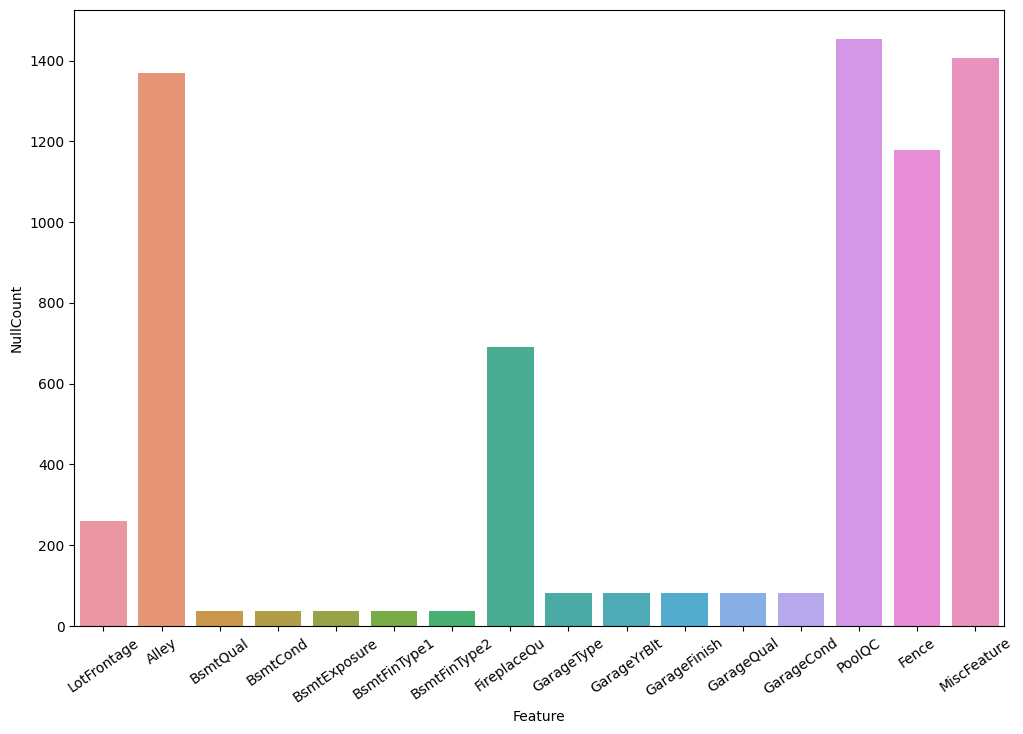

In [271]:

plt.figure(figsize=(12,8))
sns.barplot(data=housing_nullCount[housing_nullCount.NullCount >10], x="Feature", y= "NullCount")
plt.xticks(rotation=35)
plt.show()

In [272]:
# Null values dataframe
housing_nullCount[housing_nullCount['NullCount']>0]


Feature  NullCount    dtype
2    LotFrontage        259  float64
5          Alley       1369   object
24    MasVnrType          8   object
25    MasVnrArea          8  float64
29      BsmtQual         37   object
30      BsmtCond         37   object
31  BsmtExposure         38   object
32  BsmtFinType1         37   object
34  BsmtFinType2         38   object
41    Electrical          1   object
56   FireplaceQu        690   object
57    GarageType         81   object
58   GarageYrBlt         81  float64
59  GarageFinish         81   object
62    GarageQual         81   object
63    GarageCond         81   object
71        PoolQC       1453   object
72         Fence       1179   object
73   MiscFeature       1406   object

The above mentioned categorical columns have some NA values which might be consider as Null by pandas but when understanding the data dictionary its actually meant to be Not Applicable.
Here we list them out:
-  ``Alley``
-  ``BsmtQual`` | ``BsmtCond`` | ``BsmtExposure`` | ``BsmtFinType1`` | ``BsmtFinType2``
-  ``FirePlaceQu`` 
-  ``GarageType`` | ``GarageYrBlt`` | ``GarageFinish`` | ``GarageQual`` | ``GarageCond``
-  ``PoolQC`` 
-  ``Fence`` 
-  ``MiscFeature`` 


In [273]:
null_features_col = housing_nullCount[(housing_nullCount['NullCount']>0) & (housing_nullCount['dtype'] == 'object')]['Feature']

## Data Exploration and Preproccessing

In [274]:

# categorical variable
housing_cat = housing.select_dtypes(include=['object'])
housing_cat.head(4)

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0       RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
1       RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   
2       RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
3       RL   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl   

  Neighborhood Condition1  ... GarageType GarageFinish GarageQual GarageCond  \
0      CollgCr       Norm  ...     Attchd          RFn         TA         TA   
1      Veenker      Feedr  ...     Attchd          RFn         TA         TA   
2      CollgCr       Norm  ...     Attchd          RFn         TA         TA   
3      Crawfor       Norm  ...     Detchd          Unf         TA         TA   

  PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  
0          Y    NaN   NaN         NaN       WD        Normal  
1          Y    NaN   NaN         NaN       WD        Normal  
2          Y    NaN   NaN         NaN       WD        Normal  
3          Y    NaN   NaN         NaN       WD       Abnorml  

[4 rows x 43 columns]

In [275]:
# Numerical variable
housing_num = housing.select_dtypes(include=['int64','float64'])
housing_num.head(4)


MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  WoodDeckSF  \
0          2003       196.0         706           0  ...           0   
1          1976         0.0         978           0  ...         298   
2          2002       162.0         486           0  ...           0   
3          1970         0.0         216           0  ...           0   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
0           61              0          0            0         0        0   
1            0              0          0            0         0        0   
2           42              0          0            0         0        0   
3           35            272          0            0         0        0   

   MoSold  YrSold  SalePrice  
0       2    2008     208500  
1       5    2007     181500  
2       9    2008     223500  
3       2    2006     140000  

[4 rows x 37 columns]

In [276]:
# check if any duplicates row in dataset
housing.duplicated().sum()

0

> ### Bivariate / Multivariate Analysis

<AxesSubplot: >

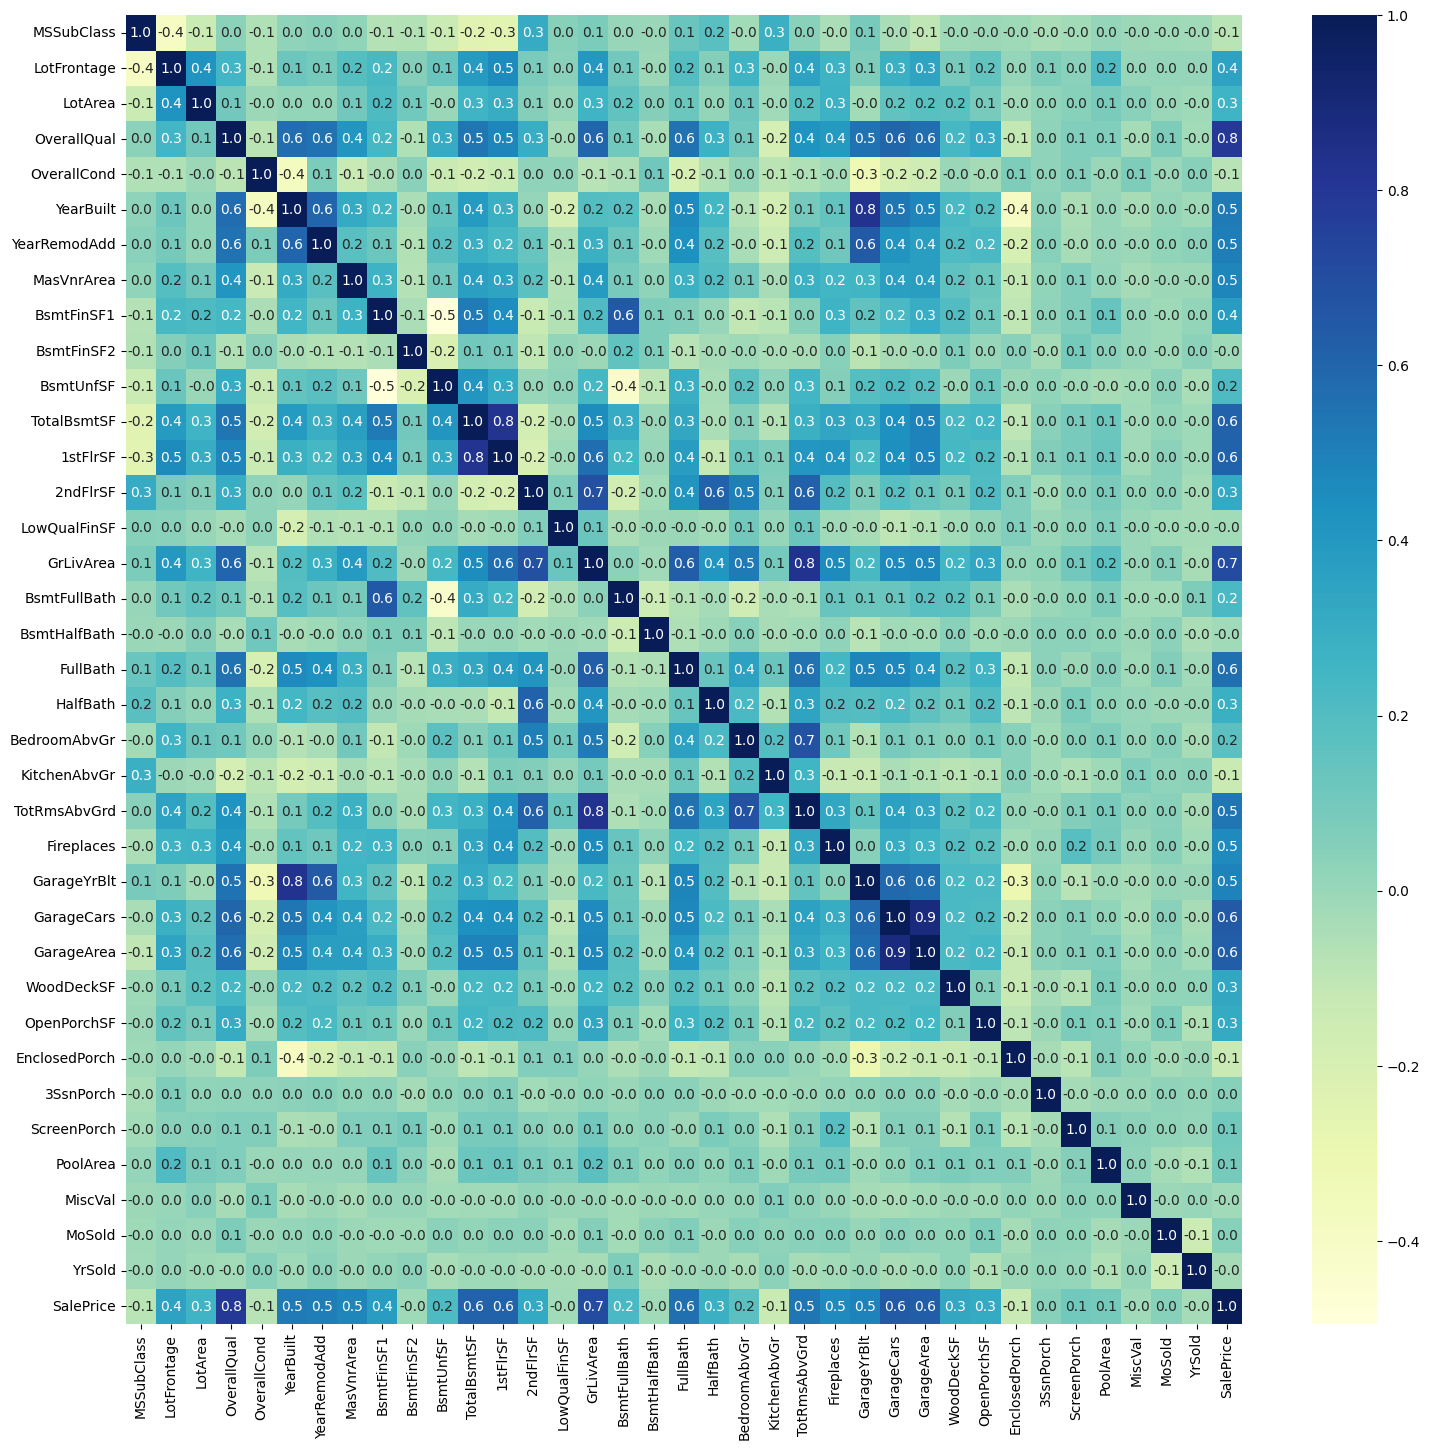

In [277]:
plt.figure(figsize=(18,17))
sns.heatmap(housing_num.corr(), annot=True, cmap='YlGnBu', fmt=".1f")

In [278]:
# list out all the numeric column which has high correlation with other variable
ls= []
corr_col = housing_num.columns
for i in range(housing_num.corr().shape[0]):
    for j in range(1+i, housing_num.corr().shape[0]):
        col_set = [corr_col[i], corr_col[j]]
        if np.abs(housing_num.corr().iloc[:,j][i]) > 0.4  :
            ls.append(col_set)
       



In [279]:
# most correlated features
ls_arr = list(set(np.array(ls).ravel()))


##### <font color='lightgreen'> Insights: </font> Features like ``GrLivArea``, ``1stFlrSF``, ``2ndFlrSF``, ``TotalBsmtSF`` is highly correlate with ``SalesPrice``

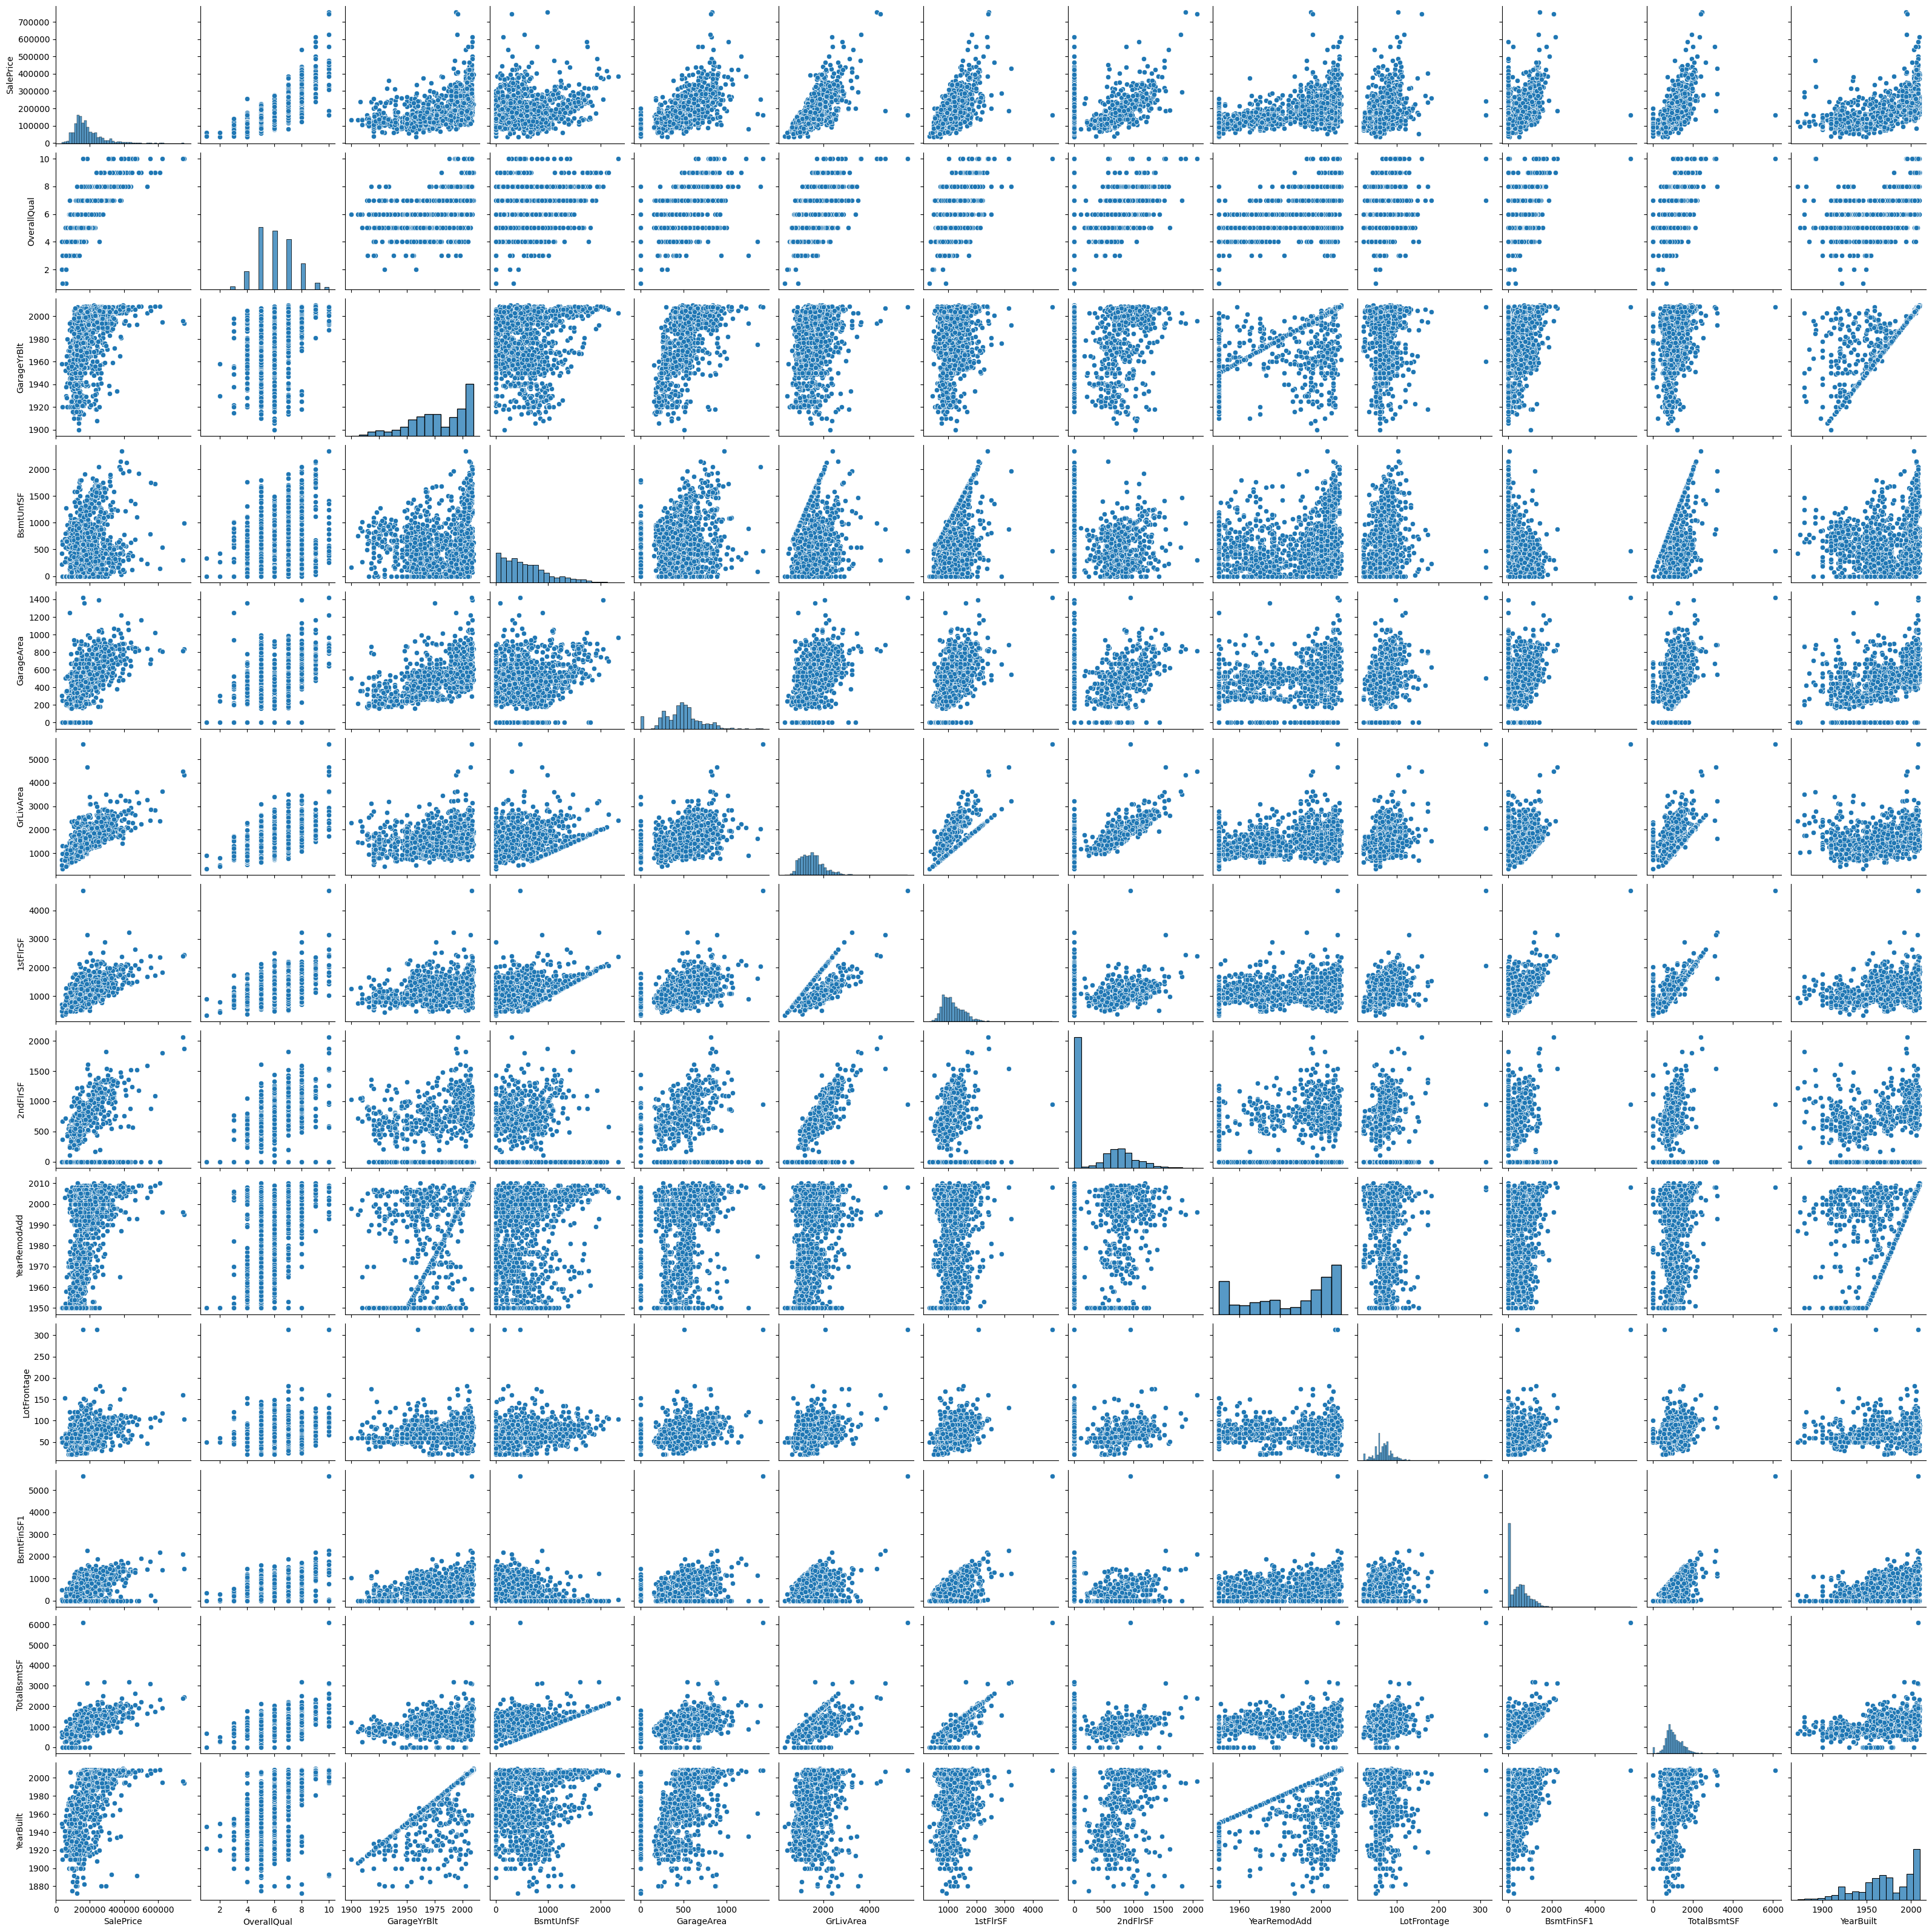

In [280]:
# let's plot the scatter plot which we got the features from ls_arr which are highly correlate with each other
sns.pairplot(housing[['SalePrice',
 'OverallQual',
 'GarageYrBlt',
 'BsmtUnfSF',
 'GarageArea',
 'GrLivArea',
 '1stFlrSF',
 '2ndFlrSF',
 'YearRemodAdd',
 'LotFrontage',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'YearBuilt']])

<AxesSubplot: xlabel='OverallQual', ylabel='SalePrice'>

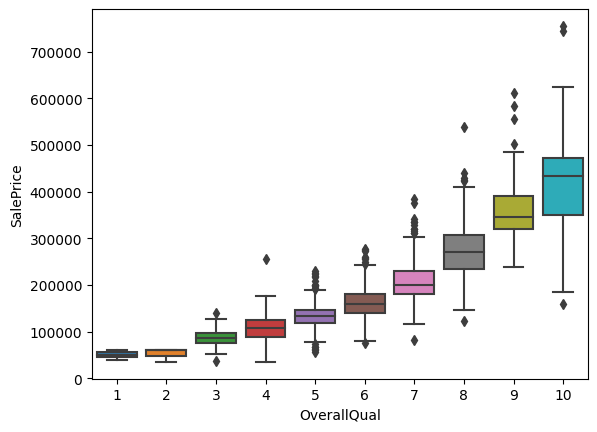

In [281]:
# OverallQual vs Sales
sns.boxplot(x='OverallQual', y='SalePrice', data=housing)


As we can see from above box plot SalePrice is high for high OverallCond Rating.

<AxesSubplot: xlabel='GarageCars', ylabel='SalePrice'>

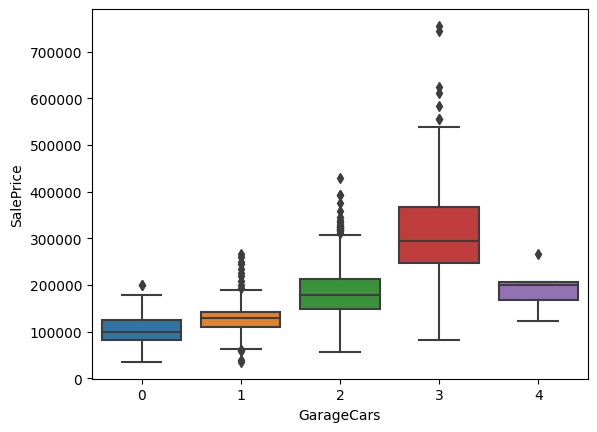

In [282]:
sns.boxplot(x='GarageCars', y='SalePrice', data=housing)

The above boxplot shows that as the capacity jumps to 4 cars SalePrice drop, but that doesn't make sence hence we need to remove those outliers from data.

In [283]:
housing = housing.drop(housing[(housing['GarageCars'] == 4) & (housing['SalePrice'] <= 300000)].index).reset_index(drop=True)


<AxesSubplot: xlabel='GarageCars', ylabel='SalePrice'>

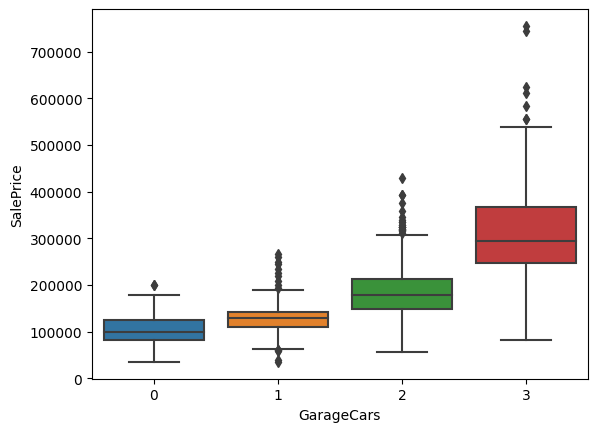

In [284]:
# after removing outliers
sns.boxplot(x='GarageCars', y='SalePrice', data=housing)

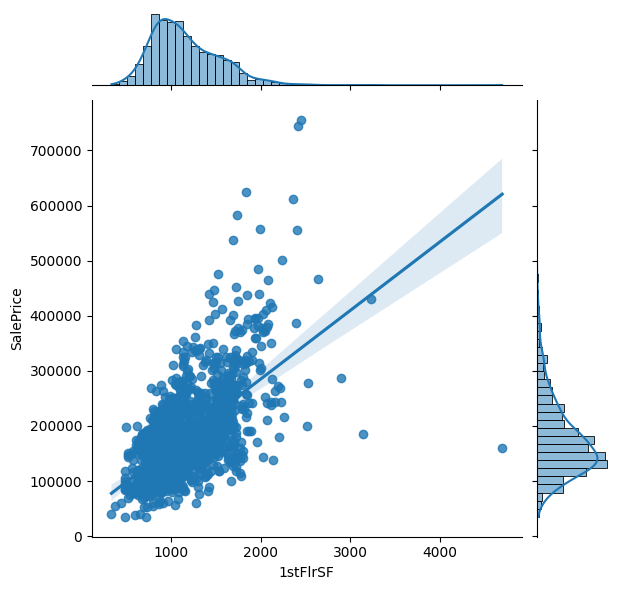

In [285]:
# 1stFlrSF vs SalePrice
sns.jointplot(x= '1stFlrSF', y='SalePrice', data=housing, kind='reg')

From the above jointplot, at the bottom right corner we can see two points which are indicating outliers in the dataset. let's remove them.

In [286]:
housing = housing.drop(housing[(housing["1stFlrSF"] > 3000) & (housing["SalePrice"] <= 200000)].index).reset_index(drop=True)


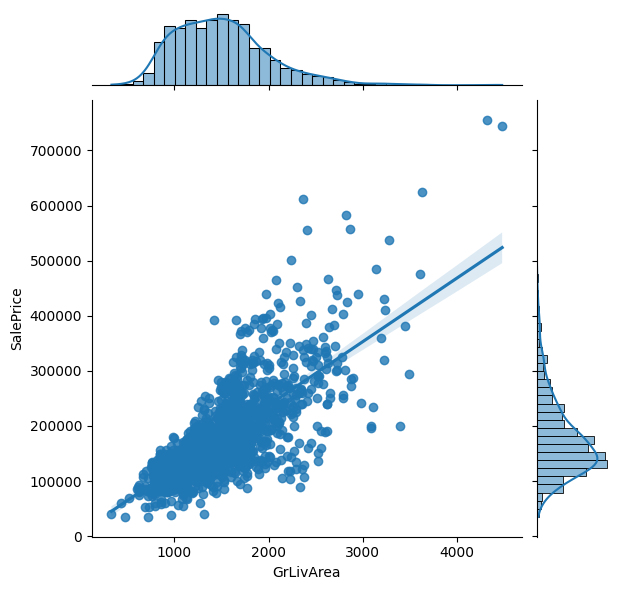

In [287]:
# GrLivArea vs SalePrice
sns.jointplot(x= 'GrLivArea', y='SalePrice', data=housing, kind='reg')


Thats look good, it does not required any modification.

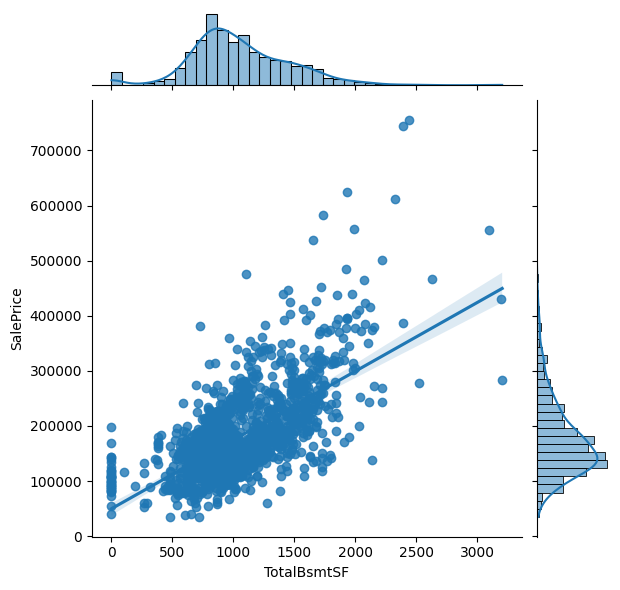

In [288]:
# TotalBsmtSF vs SalePrice
sns.jointplot(x='TotalBsmtSF', y='SalePrice', data=housing, kind='reg')

<AxesSubplot: xlabel='FullBath', ylabel='SalePrice'>

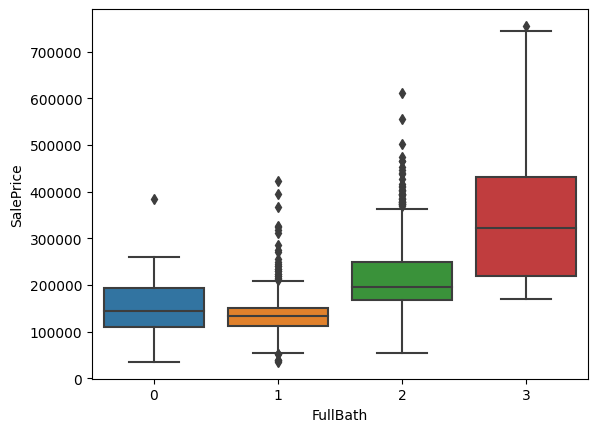

In [289]:
sns.boxplot(x='FullBath', y='SalePrice', data=housing)

> ### Univariate Analysis
- Numerical Variable

C:\Users\chirag\AppData\Roaming\Python\Python38\site-packages\seaborn\axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


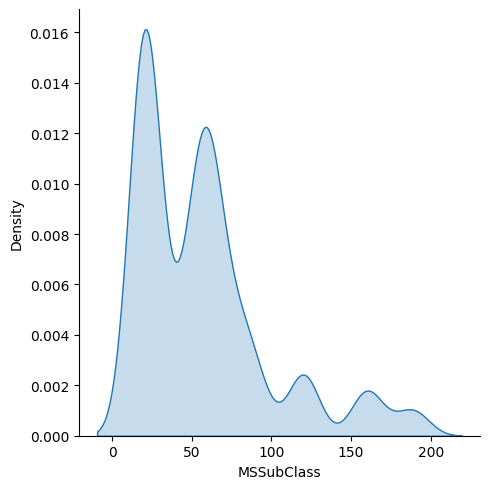

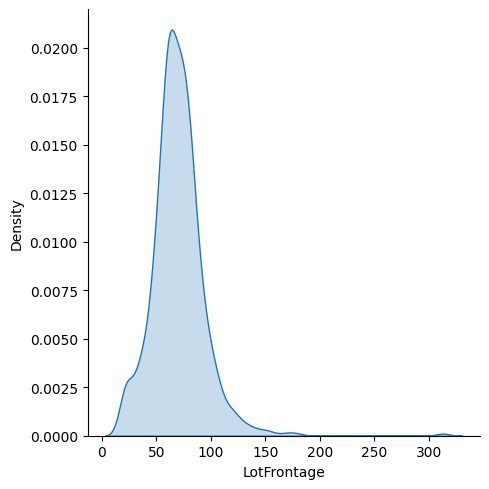

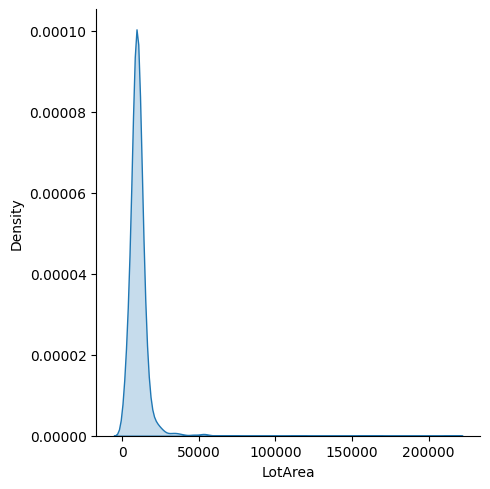

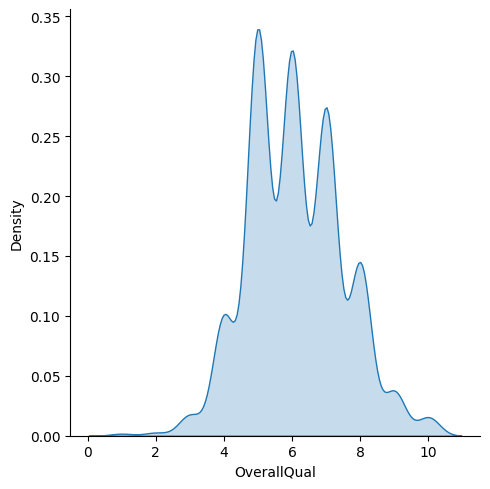

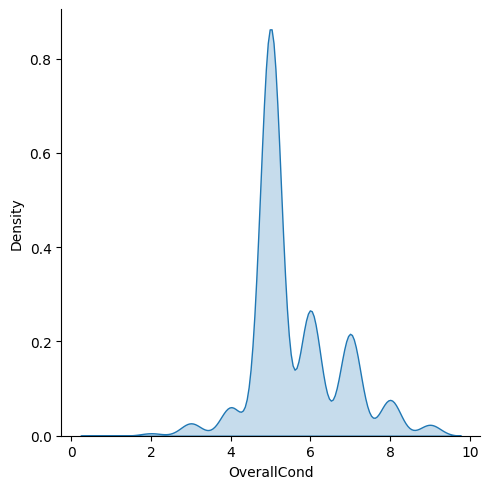

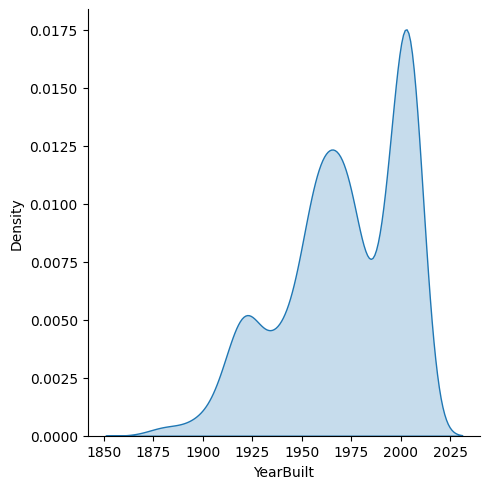

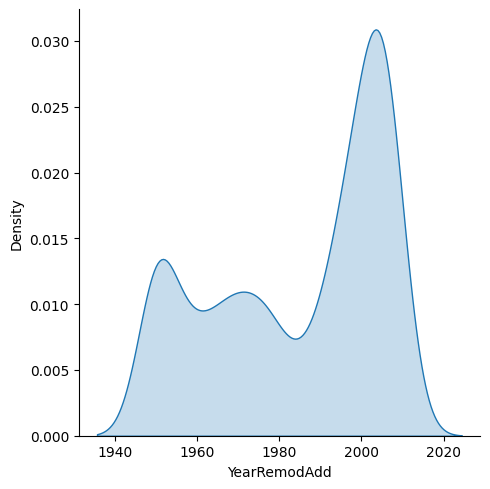

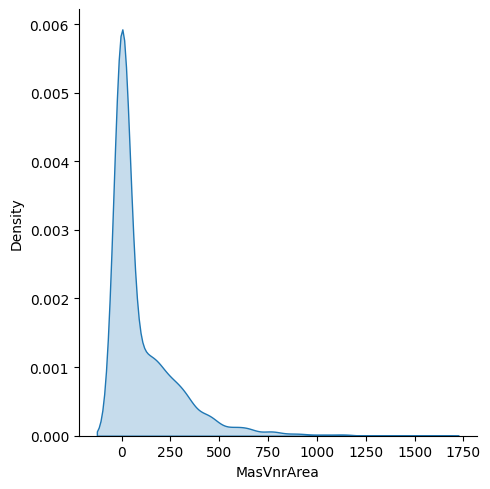

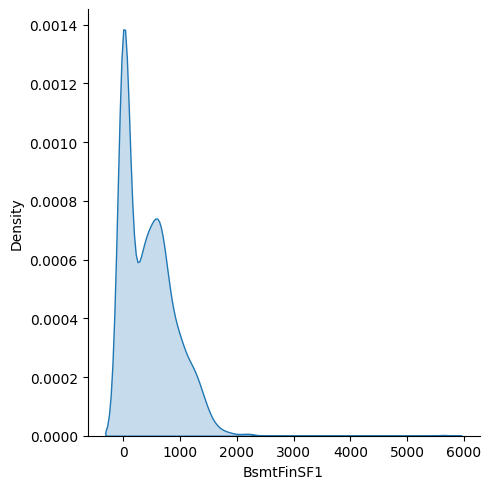

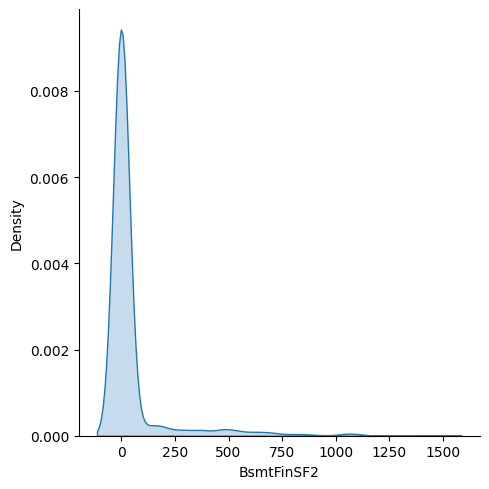

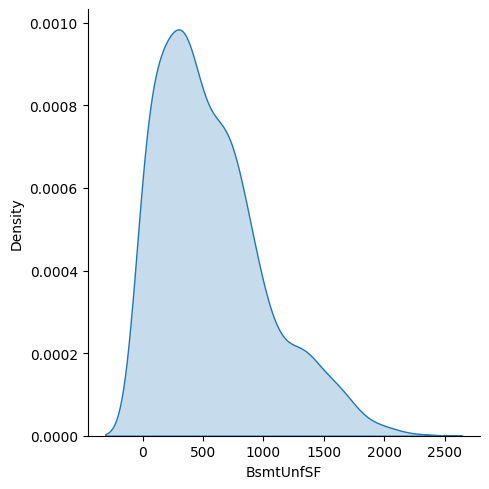

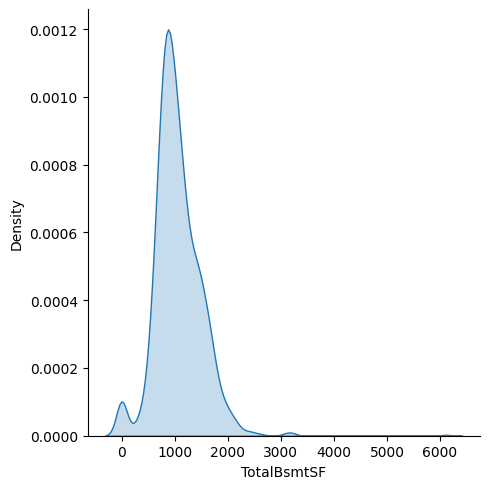

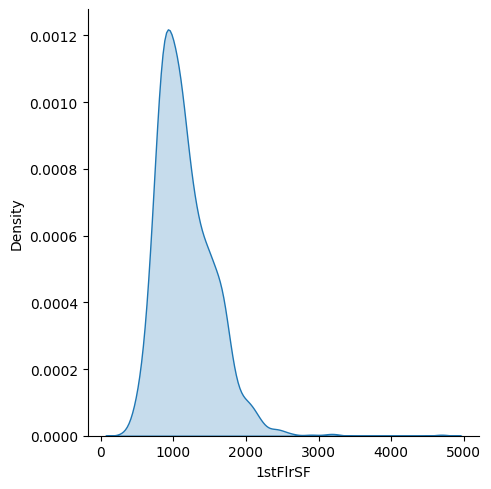

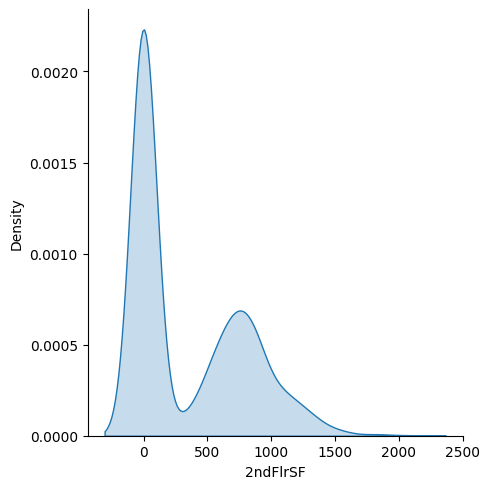

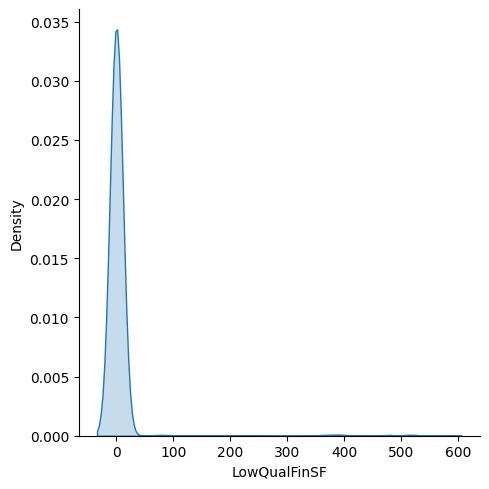

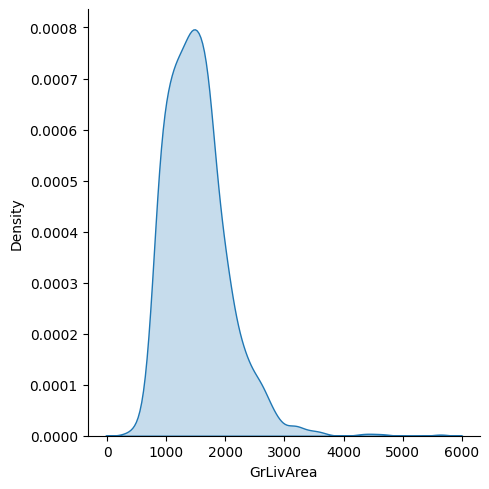

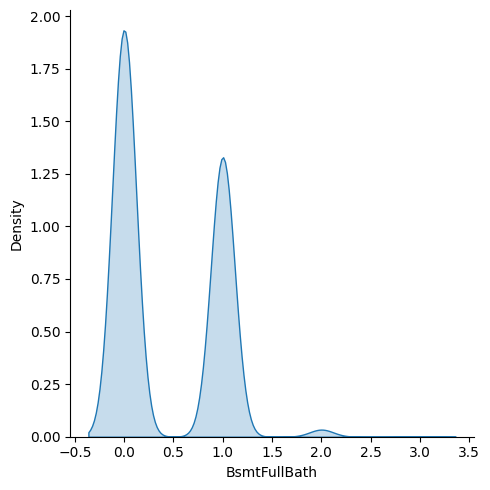

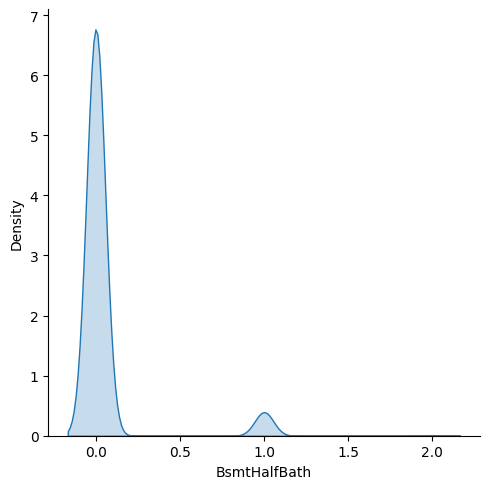

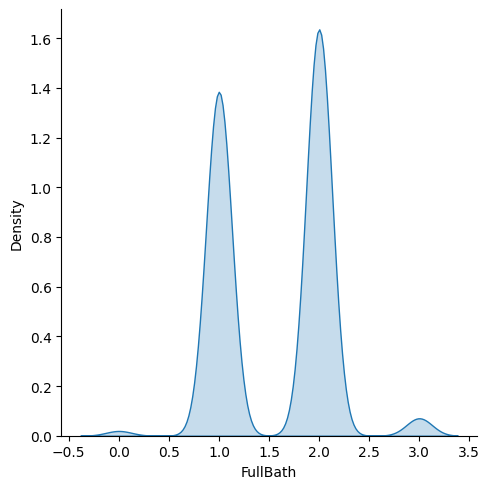

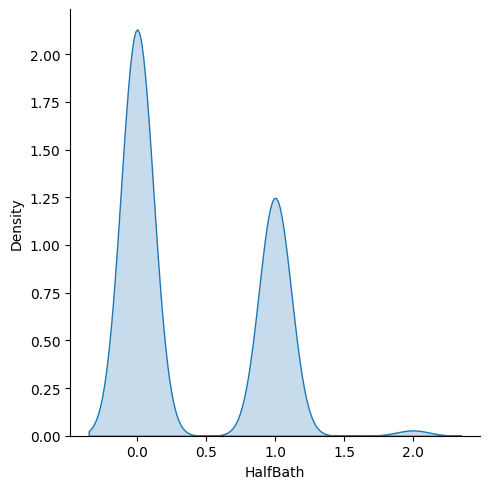

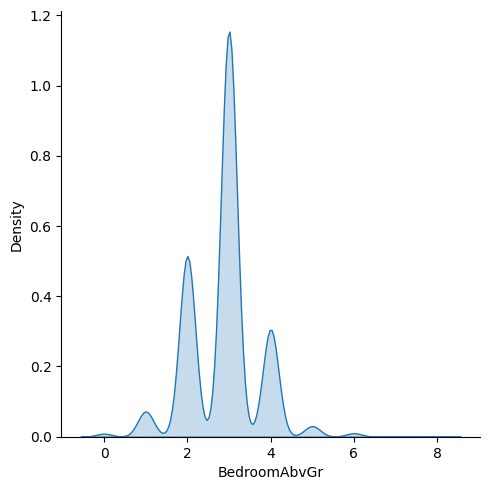

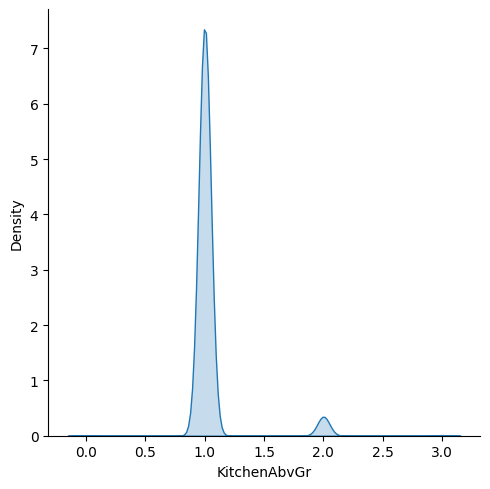

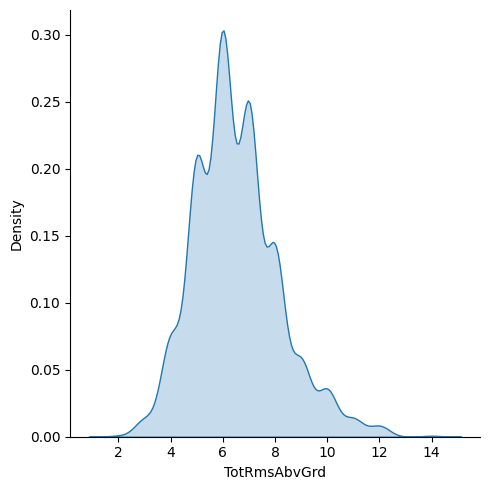

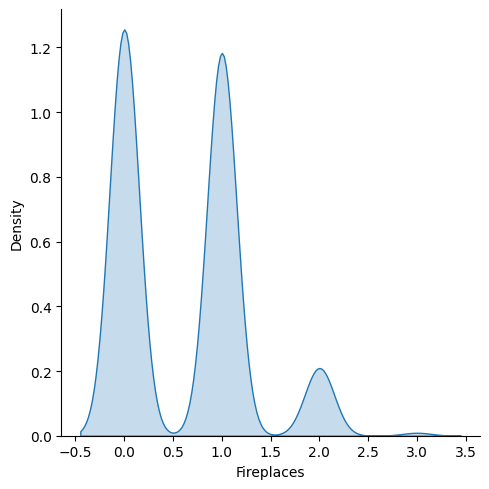

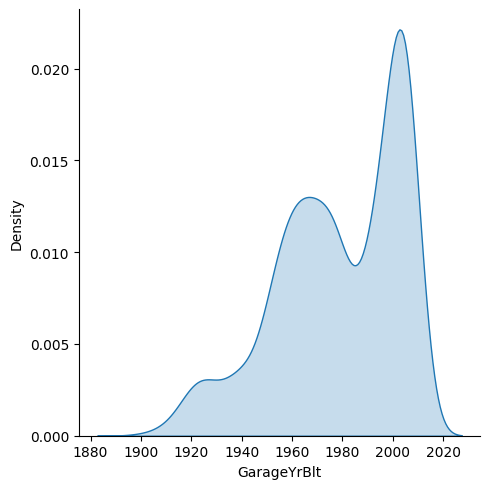

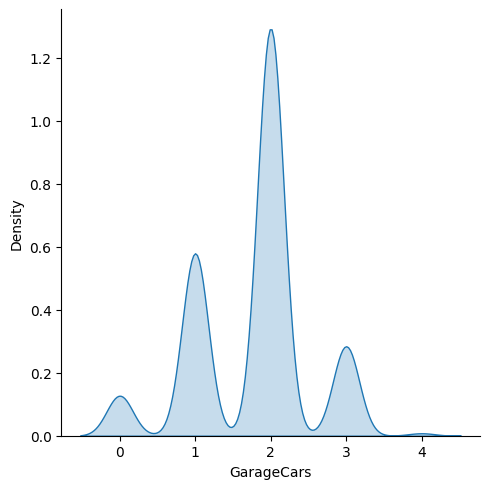

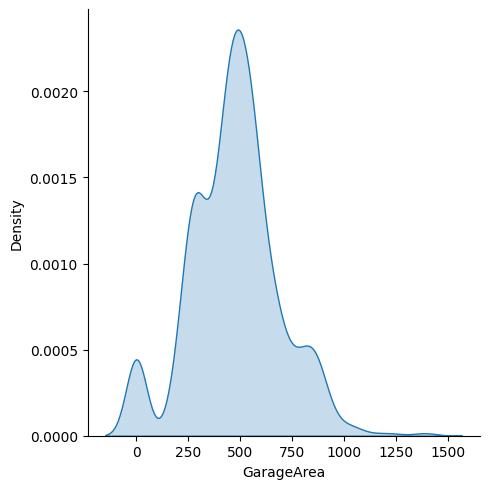

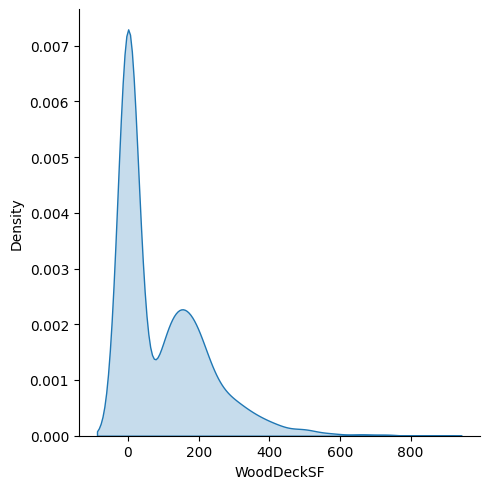

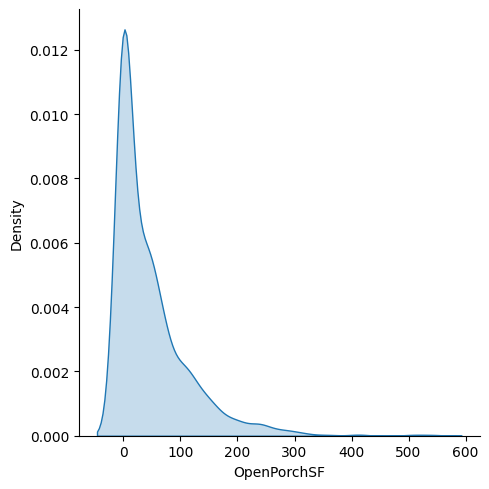

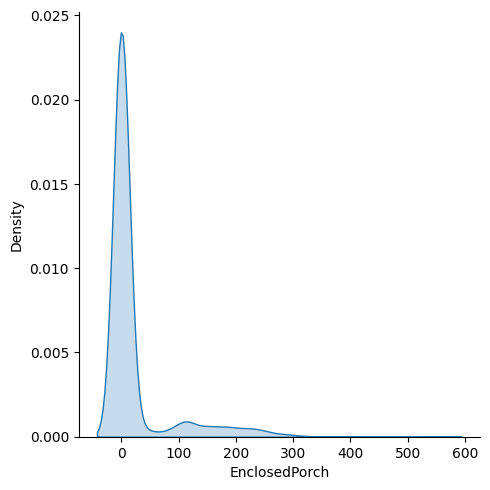

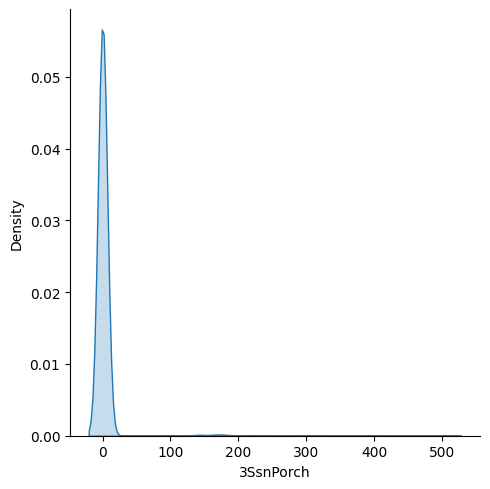

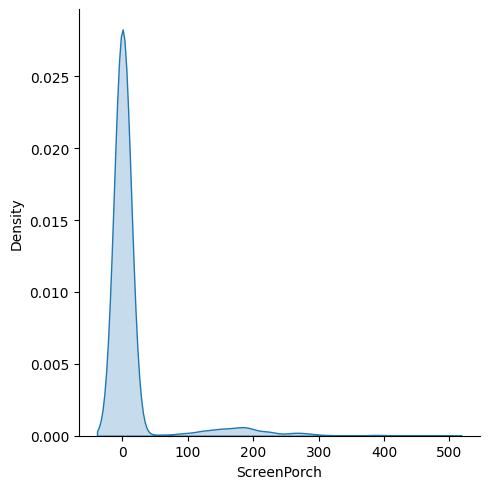

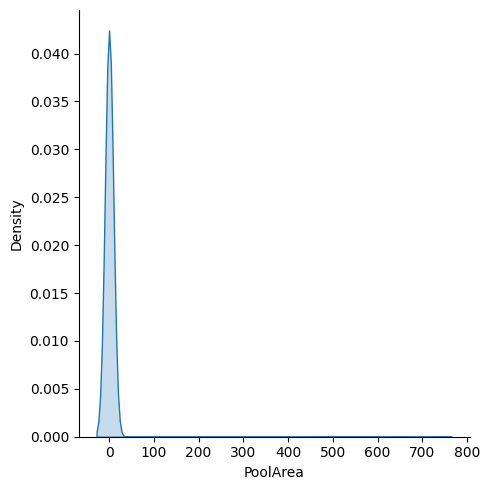

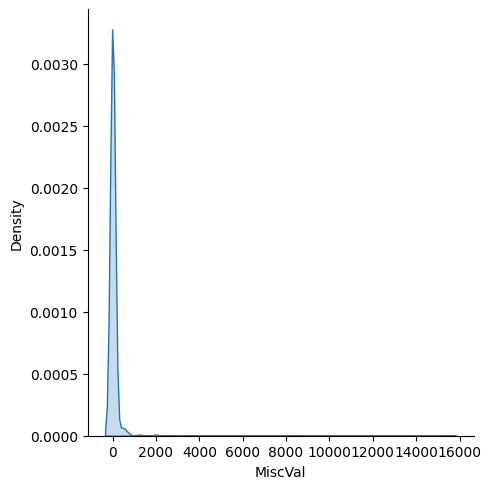

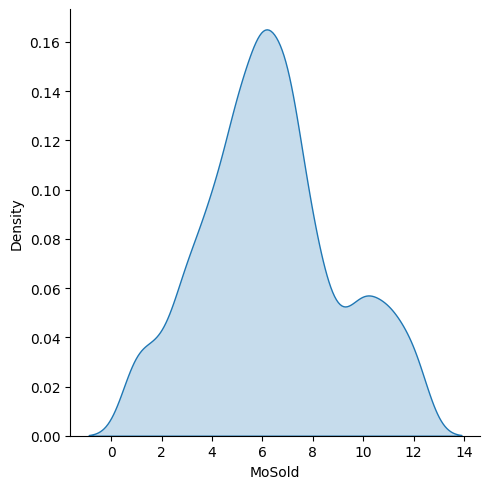

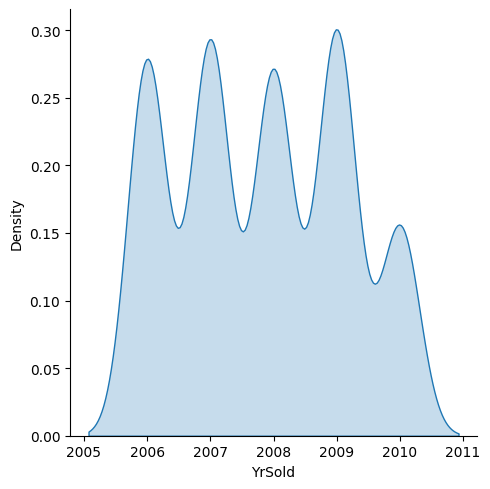

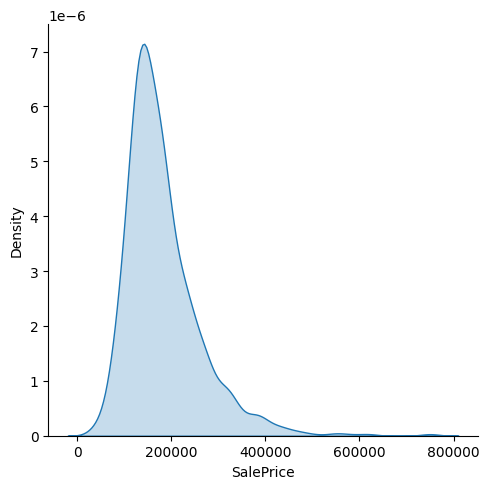

In [290]:
# plot the histogram of each numerical variable to gain understanding of their distrubution.
for col in housing_num.columns:
    sns.displot(housing_num[col], kind='kde',fill=True)

As we know from above distribution plot, our targeet variable is right skewed. 

In [291]:
# let's transform it into log scale and plot the distribution again.
housing['SalePrice'] =  np.log(housing['SalePrice'])

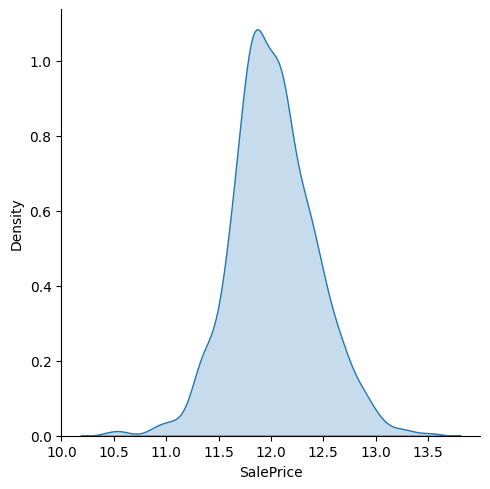

In [292]:
sns.displot(housing.SalePrice, kind='kde',fill=True)

- Categorical variable

In [293]:
# for col in housing_cat.columns:
#     plt.figure(figsize=(10,8))
#     sns.countplot(x = housing[col], hue=housing.SalePrice)
#     plt.show()

### Handling Null Values

In [294]:
housing_nullCount["NullCount"] = housing_nullCount['NullCount']*100/housing.shape[0]
housing_nullCount.sort_values(by='NullCount', ascending=False)[:20]


Feature   NullCount    dtype
71        PoolQC  100.000000   object
73   MiscFeature   96.765313   object
5          Alley   94.218858   object
72         Fence   81.142464   object
56   FireplaceQu   47.487956   object
2    LotFrontage   17.825189  float64
58   GarageYrBlt    5.574673  float64
63    GarageCond    5.574673   object
57    GarageType    5.574673   object
59  GarageFinish    5.574673   object
62    GarageQual    5.574673   object
31  BsmtExposure    2.615279   object
34  BsmtFinType2    2.615279   object
30      BsmtCond    2.546456   object
29      BsmtQual    2.546456   object
32  BsmtFinType1    2.546456   object
25    MasVnrArea    0.550585  float64
24    MasVnrType    0.550585   object
41    Electrical    0.068823   object
0     MSSubClass    0.000000    int64

### impute missing values

-  ``Alley`` replace NaN with ``None``
-  ``BsmtQual`` | ``BsmtCond`` | ``BsmtExposure`` | ``BsmtFinType1`` | ``BsmtFinType2`` replace NaN with ``None`` 
-  ``FirePlaceQu`` replace NaN with ``None``
-  ``GarageType`` |  ``GarageFinish`` | ``GarageQual`` | ``GarageCond``  replace NaN with ``None``       
-  ``GarageYrBlt`` replace NaN with 0
-  ``PoolQC`` replace NaN with ``None``
-  ``Fence`` replace NaN with ``None``
-  ``MasVnrArea	`` replace NaN with 0
-  ``MasVnrType	`` replace NaN with ``None``
-  ``MiscFeature`` replace NaN with ``None``
-  ``Electrical`` replace NaN with ``mean``
-  ``LotFrontage`` replace NaN with ``mean, mediean or mode``

In [295]:
# lets check what value should be imputed in place of NaN in LotFrontage
housing_lotFrontage_mean = housing.LotFrontage.fillna(housing.LotFrontage.mean())
housing_lotFrontage_median = housing.LotFrontage.fillna(housing.LotFrontage.median())
housing_lotFrontage_mode = housing.LotFrontage.fillna(housing.LotFrontage.mode())



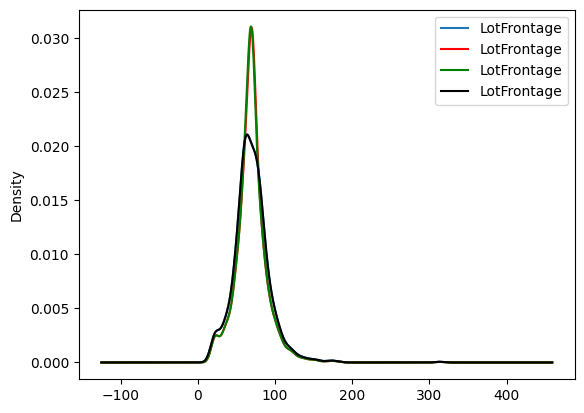

In [296]:
fig = plt.figure()
ax = fig.add_subplot(111)

housing['LotFrontage'].plot(kind='kde', ax=ax)
housing_lotFrontage_mean.plot(kind='kde', ax=ax, color='red')
housing_lotFrontage_median.plot(kind='kde', ax=ax, color='green')
housing_lotFrontage_mode.plot(kind='kde', ax=ax, color='black')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

#### <font color='green'> Conclusion:</font> since the blue curve(original distribution) is overlaped by black curve(mode). we will impute the null values of `LotFrontage` with its mode of `` 60.0``.

In [297]:
housing.LotFrontage.fillna(housing.LotFrontage.mean(), inplace=True)

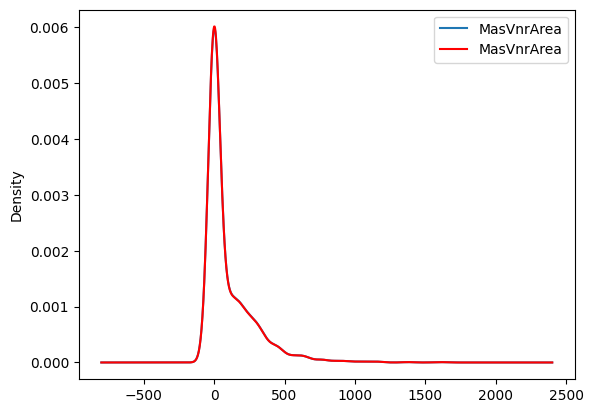

In [298]:
zero_MasVnrArea = housing["MasVnrArea"].fillna(0)

fig = plt.figure()
ax = fig.add_subplot(111)

housing['MasVnrArea'].plot(kind='kde', ax=ax)
zero_MasVnrArea.plot(kind='kde', ax=ax, color='red')


# # add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

#### <font color='green'> Conclusion:</font> since the blue curve(original distribution) is overlaped by all other curves. we will impute the null values of ``MasVnrArea`` with ``0``.

In [299]:
housing["MasVnrArea"].fillna(0, inplace=True)

In [300]:
housing['Electrical'].fillna(housing.Electrical.mode()[0], inplace=True)

In [301]:
housing["GarageYrBlt"].fillna(0, inplace=True)


In [302]:
# impute the remaining null values with None
housing.fillna("None", inplace=True)

In [303]:
print(housing.shape)
print(housing.isna().sum().sum())

(1453, 80)
0


Here we are done with imputation of all the Null values and missclassified as NA.

### Feature Engineering

> #### Derived Feature

In [304]:
housing['AgeWhenSold'] = housing.YrSold - housing.YearBuilt
housing['RemodAgeSold'] =  housing.YrSold - housing.YearRemodAdd 
housing['GarageBuiltAgeSold'] =  housing.YrSold - housing.GarageYrBlt
housing.drop(['YrSold','YearBuilt','GarageYrBlt'], axis=1, inplace=True)

> #### Ordinal Encoding

In [305]:
# let's create a new dataset out of housing dataset which contains Ordinal Encoding values.
ord_df = housing[ordinal_]

In [306]:
# Need to Encode below columns 
ord_df_ = ord_df.iloc[:,3:]
ord_df_.columns

Index(['ExterQual', 'ExterCond', 'HeatingQC', 'BsmtQual', 'BsmtCond',
       'FireplaceQu', 'GarageQual', 'GarageCond', 'KitchenQual', 'PoolQC',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'],
      dtype='object')

In [307]:
# Ordinal Encoding
cat = [['Fa', 'TA', 'Gd', 'Ex'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ['None', 'Fa', 'TA', 'Gd', 'Ex'], ['None', 'Po', 'Fa', 'TA', 'Gd'], ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ['Fa', 'TA', 'Gd', 'Ex'], ['None', 'Fa', 'Gd', 'Ex'], ['None', 'No', 'Mn', 'Av', 'Gd'], ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']]

oe = OrdinalEncoder(categories=cat)

ord_df_[ord_df_.columns] = oe.fit_transform(ord_df_[ord_df_.columns])

In [308]:
ord_df_[ord_df_.columns].tail(5)

ExterQual  ExterCond  HeatingQC  BsmtQual  BsmtCond  FireplaceQu  \
1448        1.0        2.0        4.0       3.0       3.0          3.0   
1449        1.0        2.0        2.0       3.0       3.0          3.0   
1450        3.0        3.0        4.0       2.0       4.0          4.0   
1451        1.0        2.0        3.0       2.0       3.0          0.0   
1452        2.0        2.0        3.0       2.0       3.0          0.0   

      GarageQual  GarageCond  KitchenQual  PoolQC  BsmtExposure  BsmtFinType1  \
1448         3.0         3.0          1.0     0.0           1.0           1.0   
1449         3.0         3.0          1.0     0.0           1.0           5.0   
1450         3.0         3.0          2.0     0.0           1.0           6.0   
1451         3.0         3.0          2.0     0.0           2.0           6.0   
1452         3.0         3.0          1.0     0.0           1.0           4.0   

      BsmtFinType2  
1448           1.0  
1449           3.0  
1450           1.0  
1451           3.0  
1452           2.0

> #### Nominal Encoding (dummy variable)


In [309]:
# create dummy variables
housing_dummies = pd.get_dummies(housing[housing_cat.columns], drop_first=True)

In [310]:
# drop the existing columns out of which we create dummy features
housing.drop(housing_cat.columns, axis=1, inplace=True) 

In [311]:
# concate/join the dummy features dataframe to our main housing dataset
housing= pd.concat([housing,ord_df_,housing_dummies], axis=1)

### Train Test Split

In [312]:
# X contains all independent variables which is use to make predictions
X = housing.drop(['SalePrice'], axis=1)

# y contains target variable
y = housing['SalePrice']


In [313]:
X.head()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearRemodAdd  \
0          60         65.0     8450            7            5          2003   
1          20         80.0     9600            6            8          1976   
2          60         68.0    11250            7            5          2002   
3          70         60.0     9550            7            5          1970   
4          60         84.0    14260            8            5          2000   

   MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  SaleType_ConLI  \
0       196.0         706           0        150  ...               0   
1         0.0         978           0        284  ...               0   
2       162.0         486           0        434  ...               0   
3         0.0         216           0        540  ...               0   
4       350.0         655           0        490  ...               0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                      0                     0                     0   
1                      0                     0                     0   
2                      0                     0                     0   
3                      0                     0                     0   
4                      0                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  
0                     1                      0  
1                     1                      0  
2                     1                      0  
3                     0                      0  
4                     1                      0  

[5 rows x 271 columns]

In [314]:
y.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [315]:
# lets split dataset into Train-Test in 80-20 ratio
X_train, X_test,  y_train, y_test = train_test_split(X, y, random_state=100, train_size=0.8, shuffle=True)

In [316]:
X_train.shape

(1162, 271)

### Feature Scalling

In [317]:
scale_col = list(X_train.select_dtypes(include=['int64','float64']).columns)

In [318]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# scale the numerical column
X_train[scale_col] = scaler.fit_transform(X_train[scale_col])


In [319]:
X_test[scale_col] = scaler.transform(X_test[scale_col])

## Model Building and Evaluation

### Base Model (LR)

In [320]:
lr = LinearRegression()

base_model = lr.fit(X_train, y_train)



In [321]:
# prediction based on Base_Model
y_pred_baseModel = base_model.predict(X_test)
r2Score = r2_score(y_true=y_test, y_pred=y_pred_baseModel)
print(f"R2_Score of Base_Model:{r2Score}")

R2_Score of Base_Model:-3.0543674360151404e+18


In [322]:
from sklearn.metrics import r2_score, mean_squared_error

def get_all_metrics(y_train, y_train_pred, y_test, y_pred):
    metrics = []

    # R-Squared
    print(f"R-Squared(Train): {r2_score(y_true=y_train, y_pred=y_train_pred)}")
    print(f"R-Squared(Test): {r2_score(y_true=y_test, y_pred=y_pred)}")
    metrics.append(r2_score(y_true=y_train, y_pred=y_train_pred))
    metrics.append(r2_score(y_true=y_test, y_pred=y_pred))
    # RSS
    rss_train = np.sum(np.square(y_train - y_train_pred))
    metrics.append(rss_train)
    rss_test = np.sum(np.square(y_test - y_pred))
    metrics.append(rss_test)
    print(f"RSS(Train): {rss_train}")
    print(f"RSS(Test): {rss_test}")

    # MSE
    mse_train = mean_squared_error(y_train, y_train_pred)
    metrics.append(mse_train)
    mse_test = mean_squared_error(y_test, y_pred)
    metrics.append(mse_test)
    print(f"MSE(Train): {mse_train}")
    print(f"MSE(Test): {mse_test}")   

    return metrics


### Ridge Regression Model / Optimum alpha

In [323]:
# Need to get optimum value of Lambda(alpha)
alphas = {'alpha':[0.0001,0.001,0.01,0.05,0.1,0.2,0.5,1,5,10,20,100,500,1000]}

# Create a Ridge Regression model
rdg = Ridge()

# cross Validation
rdgCV = GridSearchCV(estimator= rdg,
                     param_grid= alphas,
                     scoring= 'neg_mean_absolute_error',
                     cv = 5,
                     return_train_score= True,
                     verbose=1, n_jobs=1
)

rdgCV.fit(X_train, y_train)


Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1,
                                   5, 10, 20, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [324]:
rdgCV.best_params_

{'alpha': 10}

### Model_1 (Ridge)

In [325]:
# ridge regression object with alpha=10
ridge1 = Ridge(alpha=10)

# fit the model
ridge1.fit(X_train, y_train)

Ridge(alpha=10)

In [326]:
# make Prediction based on model_1
y_train_pred = ridge1.predict(X_train)
y_pred = ridge1.predict(X_test)

In [327]:
ridge_metrics =  get_all_metrics(y_train=y_train, y_train_pred=y_train_pred, y_test=y_test, y_pred=y_pred)


R-Squared(Train): 0.9434296540905582
R-Squared(Test): 0.9100319034015512
RSS(Train): 10.385291561078404
RSS(Test): 4.3584515178462695
MSE(Train): 0.008937428193699143
MSE(Test): 0.01497749662490127


In [328]:
ridgeCV_result = pd.DataFrame(rdgCV.cv_results_) 
ridgeCV_result.iloc[:,4:]

param_alpha             params  split0_test_score  split1_test_score  \
0       0.0001  {'alpha': 0.0001}          -0.091350          -0.088388   
1        0.001   {'alpha': 0.001}          -0.091285          -0.088301   
2         0.01    {'alpha': 0.01}          -0.091149          -0.087940   
3         0.05    {'alpha': 0.05}          -0.090840          -0.086953   
4          0.1     {'alpha': 0.1}          -0.090285          -0.086057   
5          0.2     {'alpha': 0.2}          -0.089261          -0.084916   
6          0.5     {'alpha': 0.5}          -0.087524          -0.083335   
7            1       {'alpha': 1}          -0.086500          -0.082540   
8            5       {'alpha': 5}          -0.085047          -0.079735   
9           10      {'alpha': 10}          -0.085253          -0.079502   
10          20      {'alpha': 20}          -0.086171          -0.079797   
11         100     {'alpha': 100}          -0.088792          -0.081567   
12         500     {'alpha': 500}          -0.092258          -0.086521   
13        1000    {'alpha': 1000}          -0.094703          -0.091045   

    split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           -0.081770          -0.077659          -0.098870        -0.087608   
1           -0.081710          -0.077668          -0.098769        -0.087547   
2           -0.081370          -0.077605          -0.097950        -0.087203   
3           -0.080917          -0.077016          -0.095429        -0.086231   
4           -0.080613          -0.076554          -0.093596        -0.085421   
5           -0.080197          -0.076066          -0.092552        -0.084598   
6           -0.079303          -0.075498          -0.090367        -0.083205   
7           -0.078416          -0.075158          -0.087900        -0.082103   
8           -0.077536          -0.074442          -0.081805        -0.079713   
9           -0.077685          -0.073923          -0.080841        -0.079441   
10          -0.078360          -0.073876          -0.080874        -0.079816   
11          -0.083918          -0.076697          -0.083871        -0.082969   
12          -0.096887          -0.084847          -0.091939        -0.090491   
13          -0.105126          -0.089780          -0.098858        -0.095903   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0         0.007410               12           -0.056155           -0.060323   
1         0.007378               11           -0.056173           -0.060324   
2         0.007180               10           -0.056317           -0.060348   
3         0.006626                9           -0.056734           -0.060522   
4         0.006207                8           -0.057068           -0.060741   
5         0.005954                7           -0.057512           -0.061113   
6         0.005378                6           -0.058408           -0.061911   
7         0.004795                4           -0.059361           -0.062743   
8         0.003615                2           -0.062472           -0.065271   
9         0.003722                1           -0.064429           -0.066844   
10        0.003972                3           -0.066815           -0.069096   
11        0.003923                5           -0.074162           -0.076159   
12        0.004330               13           -0.085055           -0.087057   
13        0.005592               14           -0.091708           -0.093775   

    split2_train_score  split3_train_score  split4_train_score  \
0            -0.057470           -0.061264           -0.056974   
1            -0.057482           -0.061268           -0.056984   
2            -0.057572           -0.061312           -0.057076   
3            -0.057843           -0.061475           -0.057388   
4            -0.058116           -0.061671           -0.057736   
5            -0.058559           -0.062009           -0.058235   
6            -0.059521      

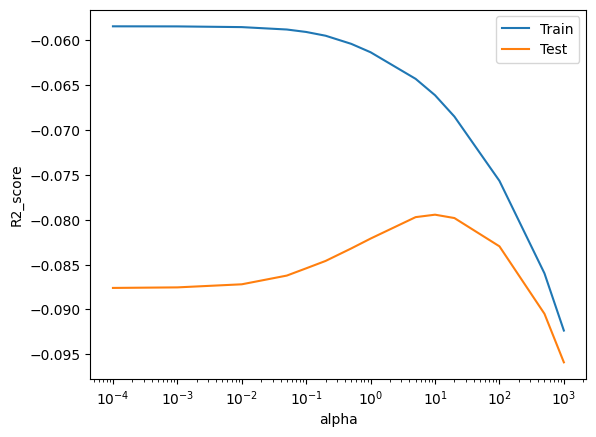

In [329]:
#  Plotting R2 score vs alpha values
plt.plot(ridgeCV_result['param_alpha'], ridgeCV_result['mean_train_score'], label='Train')
plt.plot(ridgeCV_result['param_alpha'], ridgeCV_result['mean_test_score'], label='Test')
plt.xlabel('alpha')
plt.ylabel('R2_score')
plt.xscale('log')
plt.legend()
plt.show()

#### Conclusion: As we can from above plot, the optimal value of alpha is 10

Text(37.722222222222214, 0.5, 'Y_Pred')

<Figure size 640x480 with 0 Axes>

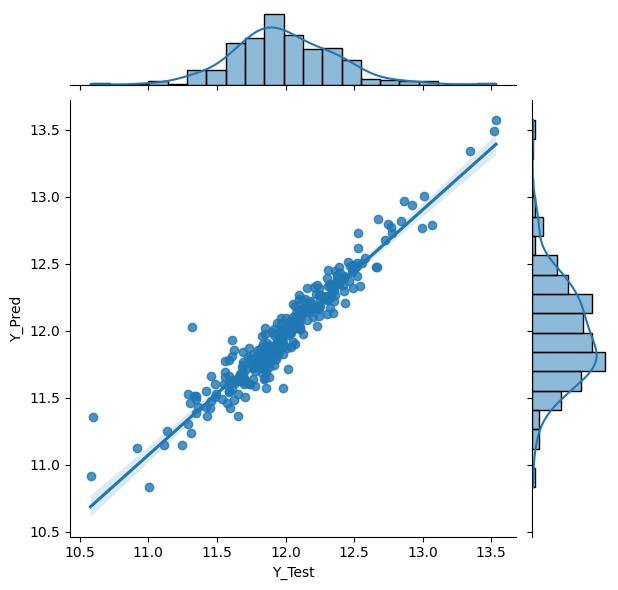

In [330]:
# plotting the y_test vs y_pred
plt.figure()
sns.jointplot(x =y_test, y= y_pred, kind='reg')
plt.xlabel('Y_Test')
plt.ylabel('Y_Pred')

### Lasso Regression Model / Optimum alpha

In [331]:


# Need to get optimum value of Lambda(alpha)
alphas = {'alpha':[0.0001,0.001,0.01,0.05,0.1,0.2,0.4,0.5,1,5,10,20,50,100,150,200,500,1000]}

# Create a Ridge Regression model
lassoBase = Lasso()

# cross Validation
lassoCV = GridSearchCV(estimator= lassoBase,
                     param_grid= alphas,
                     scoring= 'neg_mean_absolute_error',
                     cv = 5,
                     return_train_score= True,
                     verbose=1, n_jobs=1
)

lassoCV.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\chirag\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.276e-02, tolerance: 1.383e-02
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.4,
                                   0.5, 1, 5, 10, 20, 50, 100, 150, 200, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [332]:
# optimal lambda/alpha
lassoCV.best_params_

{'alpha': 0.001}

### Model_2 (lasso Regression)

In [333]:
# create the object of lasso 
lasso1 = Lasso(alpha=0.001)

# fit the model 
lasso1.fit(X_train, y_train)


Lasso(alpha=0.001)

In [334]:
# make Prediction based on model_1
y_train_predLasso = ridge1.predict(X_train)
y_predLasso = ridge1.predict(X_test)

In [335]:
lasso_metrics = get_all_metrics(y_train=y_train, y_train_pred=y_train_predLasso, y_test=y_test, y_pred=y_predLasso)

R-Squared(Train): 0.9434296540905582
R-Squared(Test): 0.9100319034015512
RSS(Train): 10.385291561078404
RSS(Test): 4.3584515178462695
MSE(Train): 0.008937428193699143
MSE(Test): 0.01497749662490127


In [336]:
lassoCV_result = pd.DataFrame(lassoCV.cv_results_) 
lassoCV_result.iloc[:,4:]

param_alpha             params  split0_test_score  split1_test_score  \
0       0.0001  {'alpha': 0.0001}          -0.087026          -0.081794   
1        0.001   {'alpha': 0.001}          -0.084466          -0.075724   
2         0.01    {'alpha': 0.01}          -0.091013          -0.091132   
3         0.05    {'alpha': 0.05}          -0.104093          -0.116601   
4          0.1     {'alpha': 0.1}          -0.137355          -0.155058   
5          0.2     {'alpha': 0.2}          -0.202997          -0.235253   
6          0.4     {'alpha': 0.4}          -0.288303          -0.319002   
7          0.5     {'alpha': 0.5}          -0.288303          -0.319002   
8            1       {'alpha': 1}          -0.288303          -0.319002   
9            5       {'alpha': 5}          -0.288303          -0.319002   
10          10      {'alpha': 10}          -0.288303          -0.319002   
11          20      {'alpha': 20}          -0.288303          -0.319002   
12          50      {'alpha': 50}          -0.288303          -0.319002   
13         100     {'alpha': 100}          -0.288303          -0.319002   
14         150     {'alpha': 150}          -0.288303          -0.319002   
15         200     {'alpha': 200}          -0.288303          -0.319002   
16         500     {'alpha': 500}          -0.288303          -0.319002   
17        1000    {'alpha': 1000}          -0.288303          -0.319002   

    split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           -0.077616          -0.075721          -0.084444        -0.081320   
1           -0.078330          -0.075134          -0.079181        -0.078567   
2           -0.092797          -0.082850          -0.089495        -0.089457   
3           -0.121021          -0.110762          -0.116989        -0.113893   
4           -0.161877          -0.148870          -0.154688        -0.151570   
5           -0.261421          -0.217747          -0.226620        -0.228808   
6           -0.348265          -0.291805          -0.307906        -0.311056   
7           -0.348265          -0.291805          -0.307906        -0.311056   
8           -0.348265          -0.291805          -0.307906        -0.311056   
9           -0.348265          -0.291805          -0.307906        -0.311056   
10          -0.348265          -0.291805          -0.307906        -0.311056   
11          -0.348265          -0.291805          -0.307906        -0.311056   
12          -0.348265          -0.291805          -0.307906        -0.311056   
13          -0.348265          -0.291805          -0.307906        -0.311056   
14          -0.348265          -0.291805          -0.307906        -0.311056   
15          -0.348265          -0.291805          -0.307906        -0.311056   
16          -0.348265          -0.291805          -0.307906        -0.311056   
17          -0.348265          -0.291805          -0.307906        -0.311056   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0         0.004186                2           -0.059610           -0.063098   
1         0.003320                1           -0.070111           -0.072361   
2         0.003465                3           -0.085591           -0.086896   
3         0.005892                4           -0.111922           -0.111283   
4         0.008216                5           -0.148865           -0.149909   
5         0.019486                6           -0.226373           -0.228248   
6         0.021661                7           -0.316600           -0.308704   
7         0.021661                7           -0.316600           -0.308704   
8         0.021661                7           -0.316600           -0.308704   
9         0.021661                7           -0.316600           -0.308704   
10        0.021661                7           -0.316600           -0.308704   
11        0.021661                7           -0.316600           -0.308704   
12        0.021661           

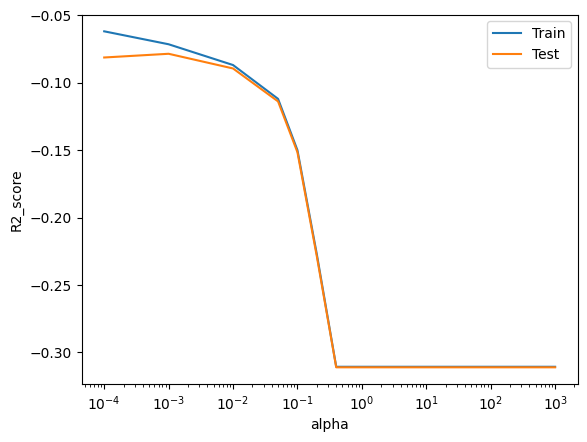

In [337]:
#  Plotting R2 score vs alpha values
plt.plot(lassoCV_result['param_alpha'], lassoCV_result['mean_train_score'], label='Train')
plt.plot(lassoCV_result['param_alpha'], lassoCV_result['mean_test_score'], label='Test')
plt.xlabel('alpha')
plt.ylabel('R2_score')
plt.xscale('log')
plt.legend()
plt.show()

#### Conclusion: As we can from above plot, the optimal value of alpha is 0.001

Text(37.722222222222214, 0.5, 'Y_Pred')

<Figure size 640x480 with 0 Axes>

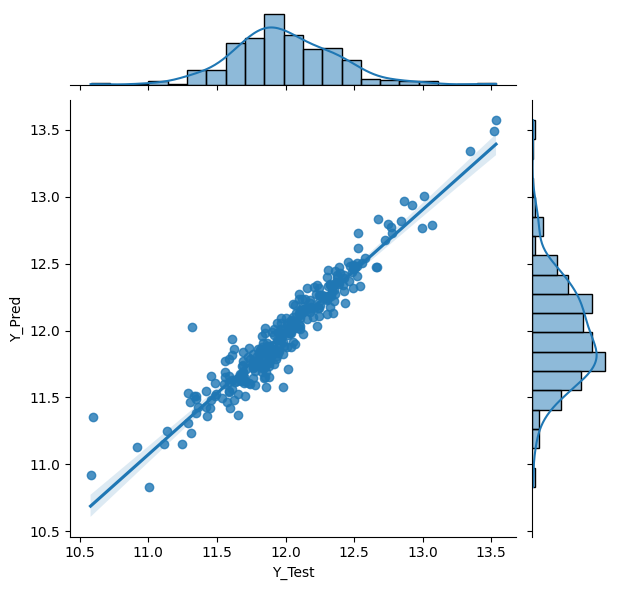

In [338]:
# plotting the y_test vs y_pred
plt.figure()
sns.jointplot(x =y_test, y= y_predLasso, kind='reg')
plt.xlabel('Y_Test')
plt.ylabel('Y_Pred')

### Comparing two models (Ridge | Lasso)

In [339]:
# create the dataframe of metrics for these two models
df_metrics = pd.DataFrame({'Metrics':['R2_Score-Train','R2_Score-Test', 'RSS-Train','RSS-Test','MSE-Train','MSE-Test'],
                            'Ridge_Model': ridge_metrics,
                            'Lasso_Model': lasso_metrics})

In [340]:
df_metrics

Metrics  Ridge_Model  Lasso_Model
0  R2_Score-Train     0.943430     0.943430
1   R2_Score-Test     0.910032     0.910032
2       RSS-Train    10.385292    10.385292
3        RSS-Test     4.358452     4.358452
4       MSE-Train     0.008937     0.008937
5        MSE-Test     0.014977     0.014977

In [341]:
# compare the coeff
comp_coeff_df = pd.DataFrame({'Fatures':X.columns, 'Ridge':ridge1.coef_ , 'Lasso': lasso1.coef_})
comp_coeff_df.sort_values(by='Ridge', ascending=False)


Fatures     Ridge     Lasso
74   Neighborhood_Crawfor  0.095811  0.093930
220        Functional_Typ  0.082078  0.067613
90   Neighborhood_StoneBr  0.075878  0.043778
51            MSZoning_RL  0.073492  0.063861
269  SaleCondition_Normal  0.070716  0.058380
..                    ...       ...       ...
110        BldgType_Twnhs -0.042474 -0.026005
215       Functional_Maj2 -0.050017 -0.000000
33            AgeWhenSold -0.055452 -0.061352
200          Heating_Grav -0.060555 -0.000000
78   Neighborhood_MeadowV -0.066100 -0.000000

[271 rows x 3 columns]

### <font color='white'>Residual Analysis<font/>


> ### Lasso

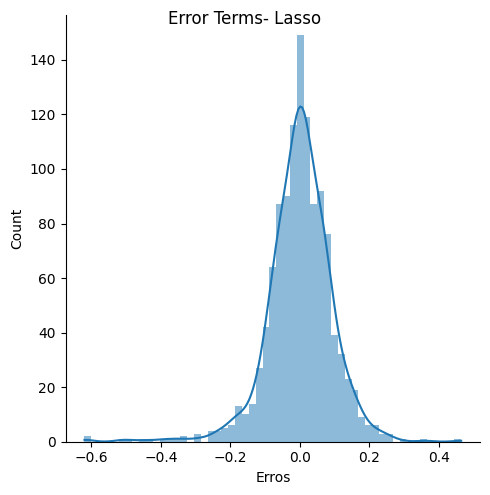

In [342]:
# lets analyze the residual before prediction on test data set.

res = y_train - y_train_predLasso
sns.displot(res, edgecolor=None, kde=True)
plt.suptitle('Error Terms- Lasso')
plt.xlabel('Erros')
plt.show()

> ### Ridge

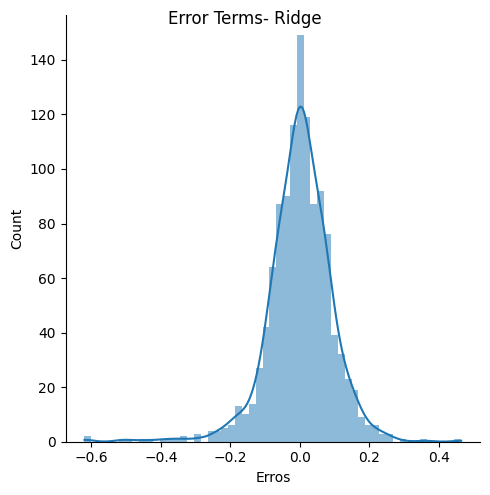

In [343]:
# lets analyze the residual before prediction on test data set.

res = y_train - y_train_pred
sns.displot(res, edgecolor=None, kde=True)
plt.suptitle('Error Terms- Ridge')
plt.xlabel('Erros')
plt.show()

### Top 10 features which are contributing to predict ``SalePrice``

In [344]:
comp_coeff_df.sort_values(by='Ridge', ascending=False)[:10]

Fatures     Ridge     Lasso
74   Neighborhood_Crawfor  0.095811  0.093930
220        Functional_Typ  0.082078  0.067613
90   Neighborhood_StoneBr  0.075878  0.043778
51            MSZoning_RL  0.073492  0.063861
269  SaleCondition_Normal  0.070716  0.058380
14              GrLivArea  0.068610  0.126105
3             OverallQual  0.065163  0.075356
263          SaleType_New  0.062982  0.104191
49            MSZoning_FV  0.059358  0.056983
94        Condition1_Norm  0.052539  0.035963

### Assignment Que
### What will change if we double the alpha 

> #### for Ridge (alpha = 20)

In [345]:
ridge2 = Ridge(alpha=20)

ridge2.fit(X_train, y_train)

y_train_predRgd2 = ridge2.predict(X_train)
y_test_predRgd2 = ridge2.predict(X_test)

In [346]:
ridge2_metrics = get_all_metrics(y_train=y_train, y_train_pred=y_train_predRgd2, y_test=y_test, y_pred=y_test_predRgd2)

R-Squared(Train): 0.9397991413866011
R-Squared(Test): 0.9111992018907007
RSS(Train): 11.051787979664052
RSS(Test): 4.301902429178528
MSE(Train): 0.009511005146010372
MSE(Test): 0.014783169859720028


> #### for Lasso (alpha = 0.002)

In [347]:
lasso2 = Lasso(alpha=0.002)

lasso2.fit(X_train, y_train)

y_train_predLasso2 = lasso2.predict(X_train)
y_test_predLasso2 = lasso2.predict(X_test)

In [348]:
lasso2_metrics = get_all_metrics(y_train=y_train, y_train_pred=y_train_predLasso2, y_test=y_test, y_pred=y_test_predLasso2)

R-Squared(Train): 0.9243454433962055
R-Squared(Test): 0.9099269893112073
RSS(Train): 13.888807212037584
RSS(Test): 4.363534019239442
MSE(Train): 0.011952501903646802
MSE(Test): 0.014994962265427634


In [356]:
df_metrics_comp = pd.DataFrame({'Metrics':['R2_Score-Train','R2_Score-Test', 'RSS-Train','RSS-Test','MSE-Train','MSE-Test'],
                            'Ridge_Model(alpha:10)': ridge_metrics,
                            'Lasso_Model(alpha:0.001)': lasso_metrics,
                            'Ridge_Model(alpha:20)': ridge2_metrics,
                            'Lasso_Model(alpha:0.002':lasso2_metrics})

In [357]:
df_metrics_comp

Metrics  Ridge_Model(alpha:10)  Lasso_Model(alpha:0.001)  \
0  R2_Score-Train               0.943430                  0.943430   
1   R2_Score-Test               0.910032                  0.910032   
2       RSS-Train              10.385292                 10.385292   
3        RSS-Test               4.358452                  4.358452   
4       MSE-Train               0.008937                  0.008937   
5        MSE-Test               0.014977                  0.014977   

   Ridge_Model(alpha:20)  Lasso_Model(alpha:0.002  
0               0.939799                 0.924345  
1               0.911199                 0.909927  
2              11.051788                13.888807  
3               4.301902                 4.363534  
4               0.009511                 0.011953  
5               0.014783                 0.014995

In [365]:
# drop the top first 5 features and build new model 
drop_5 = ["Neighborhood_Crawfor","Functional_Typ","Neighborhood_StoneBr" ,"MSZoning_RL","SaleCondition_Normal"]

## drop them from train and test data
X_train_dropped = X_train.drop(drop_5, axis=1)
X_test_dropped = X_test.drop(drop_5, axis=1)

In [366]:
# Need to get optimum value of Lambda(alpha)
alphas = {'alpha':[0.0001,0.001,0.01,0.05,0.1,0.2,0.4,0.5,1,5,10,20,50,100,150,200,500,1000]}

# Create a Ridge Regression model
lassoBase = Lasso()

# cross Validation
lassoCV = GridSearchCV(estimator= lassoBase,
                     param_grid= alphas,
                     scoring= 'neg_mean_absolute_error',
                     cv = 5,
                     return_train_score= True,
                     verbose=1, n_jobs=1
)

lassoCV.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\chirag\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.276e-02, tolerance: 1.383e-02
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=5, estimator=Lasso(), n_jobs=1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.4,
                                   0.5, 1, 5, 10, 20, 50, 100, 150, 200, 500,
                                   1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [367]:
lassoCV.best_params_

{'alpha': 0.001}

In [368]:
# create the object of lasso 
lasso3 = Lasso(alpha=0.001)

# fit the model 
lasso3.fit(X_train, y_train)

y_train_predLasso3 = lasso3.predict(X_train)
y_test_predLasso3 = lasso3.predict(X_test)



In [371]:
# compare the coeff
top_coeff_df = pd.DataFrame({'Fatures':X.columns, 'Lasso':lasso3.coef_ })
top_coeff_df.sort_values(by='Lasso', ascending=False)[:5]

Fatures     Lasso
14              GrLivArea  0.126105
263          SaleType_New  0.104191
74   Neighborhood_Crawfor  0.093930
3             OverallQual  0.075356
220        Functional_Typ  0.067613